In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
%load_ext autoreload

## Data cleaning

In [2]:
from functions import clean_data

In [3]:
%autoreload
df_train = pd.read_csv("data/no1_train.csv")
df_test = pd.read_csv("data/no1_validation.csv")  # pd.read_csv("data/no1_test.csv")

# NEGATE FLOW
#df_train["flow"] = -1.0 * df_train["flow"]
#df_test["flow"] = -1.0 * df_test["flow"]


percent = 0.005
upper_bound = df_train.y.quantile(1-percent/2)
lower_bound = df_train.y.quantile(percent/2)

print("Upper bound:", upper_bound)
print("Lower bound:", lower_bound)


df_train = clean_data(df_train, upper_bound, lower_bound)
df_test = clean_data(df_test, upper_bound, lower_bound)

Upper bound: 1965.4099018235388
Lower bound: -876.8264394156931
Points clamped: 1126. In percent 0.5002%
Points clamped: 306. In percent 1.0876%


## Define features

In [4]:
df_train.head()

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow
0,2019-01-09 14:10:00,1591.839,141.928,11.5,74.428,0.0,1819.695,341.330021,10.0,-4417.4
1,2019-01-09 14:15:00,1591.839,141.928,11.5,74.428,0.0,1819.695,330.114330,10.0,-4417.4
2,2019-01-09 14:20:00,1591.839,141.928,11.5,74.428,0.0,1819.695,323.877221,10.0,-4417.4
3,2019-01-09 14:25:00,1591.839,141.928,11.5,74.428,0.0,1819.695,296.438463,10.0,-4417.4
4,2019-01-09 14:30:00,1591.839,141.928,11.5,74.428,0.0,1819.695,269.097132,10.0,-4417.4


In [5]:
from functions import add_structural_imbalance, add_time_features, add_lag_features

column_indcies = ['hydro', 'micro', 'thermal', 'wind', 'total',
        'sys_reg', 'flow', 'Minute sine', 'Minute cosine', 'Hour sine',
       'Hour cosine', 'Day sine', 'Day cosine', 'Month sine', 'Month cosine',
       'Week sine', 'Week cosine', 'prev_y_288', 'prev_y_1'] ## y should be last column,

lags = [1,12*24]
addNoise = False # sigma = 10
lag_mean_prev_day = False
struc_imbalance = False

target_name = "y_struc_imb" if struc_imbalance else "y"
column_indcies.append(target_name)

df_train = add_time_features(df_train)
if struc_imbalance: df_train = add_structural_imbalance(df_train, feature_name=target_name) # new y = y_struc_imb
df_train = add_lag_features(df_train, feature=target_name, lags=lags, addNoise=addNoise, addMeanprevDay=lag_mean_prev_day)


df_test = add_time_features(df_test)
if struc_imbalance: df_test = add_structural_imbalance(df_test, feature_name=target_name)
df_test = add_lag_features(df_test, feature=target_name, lags=lags, addNoise=addNoise, addMeanprevDay=lag_mean_prev_day)

df_train.head()

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow,...,Hour sine,Hour cosine,Day sine,Day cosine,Month sine,Month cosine,Week sine,Week cosine,prev_y_1,prev_y_288
288,2019-01-10 14:10:00,2060.334,138.458,11.5,63.212,0.0,2273.504,374.887951,0.0,-4236.4,...,-0.5,-0.866025,0.171176,0.98524,0.5,0.866025,0.239316,0.970942,376.374054,341.330021
289,2019-01-10 14:15:00,2060.334,138.458,11.5,63.212,0.0,2273.504,368.561429,0.0,-4236.4,...,-0.5,-0.866025,0.171176,0.98524,0.5,0.866025,0.239316,0.970942,374.887951,330.114330
290,2019-01-10 14:20:00,2060.334,138.458,11.5,63.212,0.0,2273.504,364.915513,0.0,-4236.4,...,-0.5,-0.866025,0.171176,0.98524,0.5,0.866025,0.239316,0.970942,368.561429,323.877221
291,2019-01-10 14:25:00,2060.334,138.458,11.5,63.212,0.0,2273.504,337.967473,0.0,-4236.4,...,-0.5,-0.866025,0.171176,0.98524,0.5,0.866025,0.239316,0.970942,364.915513,296.438463
292,2019-01-10 14:30:00,2060.334,138.458,11.5,63.212,0.0,2273.504,326.137265,0.0,-4236.4,...,-0.5,-0.866025,0.171176,0.98524,0.5,0.866025,0.239316,0.970942,337.967473,269.097132


In [10]:
df_test.head()

,start_time,hydro,micro,thermal,wind,river,total,y,sys_reg,flow,...,Hour sine,Hour cosine,Day sine,Day cosine,Month sine,Month cosine,Week sine,Week cosine,prev_y_1,prev_y_288
288,2021-03-02 03:30:00,207.02,36.035,23.1,0.0,0.0,266.155,113.285294,0.0,-2133.3,...,0.707107,0.707107,0.034398,0.999408,1.0,6.123234e-17,0.885456,0.464723,155.585970,52.119595
289,2021-03-02 03:35:00,207.02,36.035,23.1,0.0,0.0,266.155,96.460997,0.0,-2133.3,...,0.707107,0.707107,0.034398,0.999408,1.0,6.123234e-17,0.885456,0.464723,113.285294,90.374541
290,2021-03-02 03:40:00,207.02,36.035,23.1,0.0,0.0,266.155,104.394813,0.0,-2133.3,...,0.707107,0.707107,0.034398,0.999408,1.0,6.123234e-17,0.885456,0.464723,96.460997,88.435063
291,2021-03-02 03:45:00,207.02,36.035,23.1,0.0,0.0,266.155,80.840222,0.0,-2133.3,...,0.707107,0.707107,0.034398,0.999408,1.0,6.123234e-17,0.885456,0.464723,104.394813,53.375518
292,2021-03-02 03:50:00,207.02,36.035,23.1,0.0,0.0,266.155,39.812120,0.0,-2133.3,...,0.707107,0.707107,0.034398,0.999408,1.0,6.123234e-17,0.885456,0.464723,80.840222,65.496683


In [6]:
## Selectes only the wanted features
train_data = df_train[column_indcies]
test_data = df_test[column_indcies]
train_data.head()

,hydro,micro,thermal,wind,total,sys_reg,flow,Minute sine,Minute cosine,Hour sine,Hour cosine,Day sine,Day cosine,Month sine,Month cosine,Week sine,Week cosine,prev_y_288,prev_y_1,y
288,2060.334,138.458,11.5,63.212,2273.504,0.0,-4236.4,8.660254e-01,5.000000e-01,-0.5,-0.866025,0.171176,0.98524,0.5,0.866025,0.239316,0.970942,341.330021,376.374054,374.887951
289,2060.334,138.458,11.5,63.212,2273.504,0.0,-4236.4,1.000000e+00,2.832769e-16,-0.5,-0.866025,0.171176,0.98524,0.5,0.866025,0.239316,0.970942,330.114330,374.887951,368.561429
290,2060.334,138.458,11.5,63.212,2273.504,0.0,-4236.4,8.660254e-01,-5.000000e-01,-0.5,-0.866025,0.171176,0.98524,0.5,0.866025,0.239316,0.970942,323.877221,368.561429,364.915513
291,2060.334,138.458,11.5,63.212,2273.504,0.0,-4236.4,5.000000e-01,-8.660254e-01,-0.5,-0.866025,0.171176,0.98524,0.5,0.866025,0.239316,0.970942,296.438463,364.915513,337.967473
292,2060.334,138.458,11.5,63.212,2273.504,0.0,-4236.4,5.665539e-16,-1.000000e+00,-0.5,-0.866025,0.171176,0.98524,0.5,0.866025,0.239316,0.970942,269.097132,337.967473,326.137265


In [11]:
%autoreload
from functions import WindowGenerator, build_model, fit_and_plot
generator = WindowGenerator(train_data=train_data, test_data=test_data , target=target_name,
							n_input=12*24*2, n_output=1, shift=1, num_predictions=12*2, batch_size=32)

generator.getTrainData()

<MapDataset element_spec=(TensorSpec(shape=(None, 576, 19), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [8]:
#model = build_model(generator.getInputShape(), load_prev_model=False)
model = build_model(load_prev_model="model_weights/GRU_64_10epochs_input_576_prev_y1_prev_y288.h5")
model.summary()

Loaded model from file: model_weights/GRU_64_10epochs_input_576_prev_y1_prev_y288.h5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                16320     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,385
Trainable params: 16,385
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Shuffeles data
model = fit_and_plot(model, generator.getTrainData(), generator.getTestData(), epochs=4)

Epoch 1/4


ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 576, 18), found shape=(None, 288, 19)


100%|██████████| 23/23 [00:01<00:00, 16.70it/s]


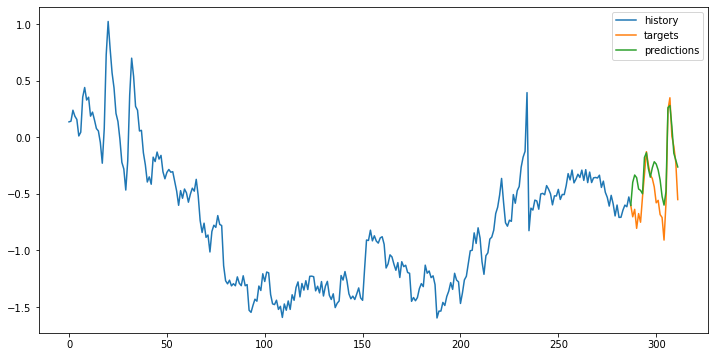

100%|██████████| 23/23 [00:01<00:00, 16.10it/s]


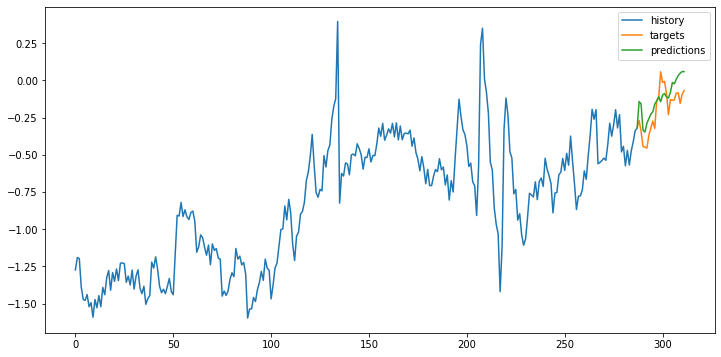

100%|██████████| 23/23 [00:01<00:00, 18.53it/s]


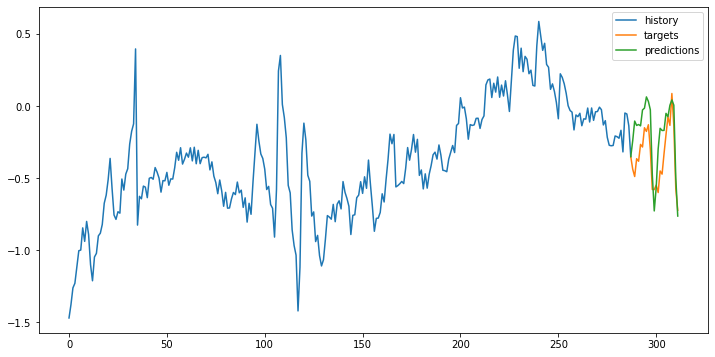

100%|██████████| 23/23 [00:01<00:00, 18.07it/s]


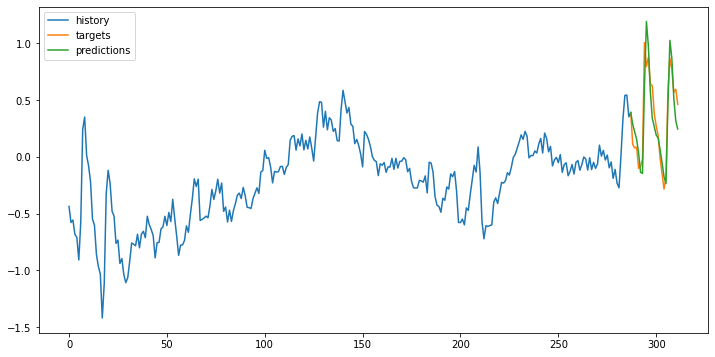

100%|██████████| 23/23 [00:01<00:00, 18.01it/s]


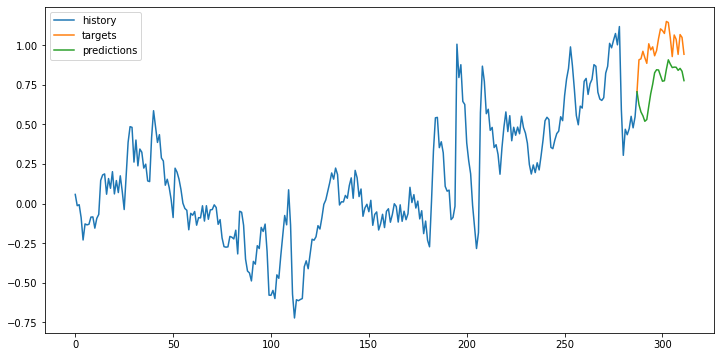

100%|██████████| 23/23 [00:01<00:00, 18.44it/s]


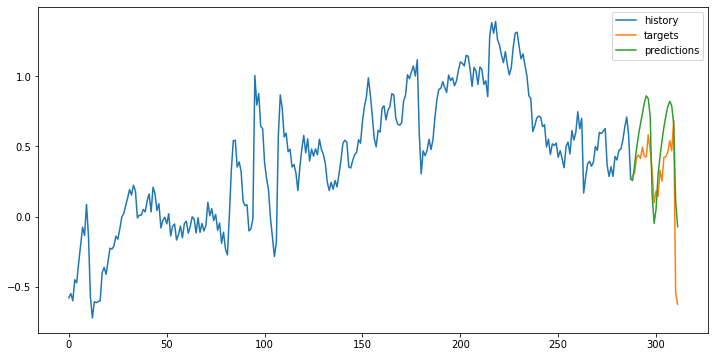

100%|██████████| 23/23 [00:01<00:00, 18.00it/s]


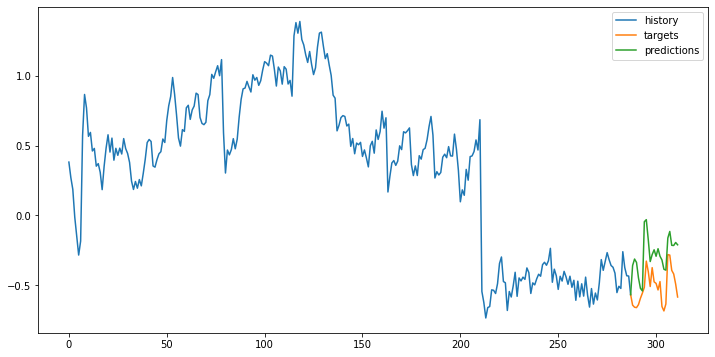

100%|██████████| 23/23 [00:01<00:00, 18.43it/s]


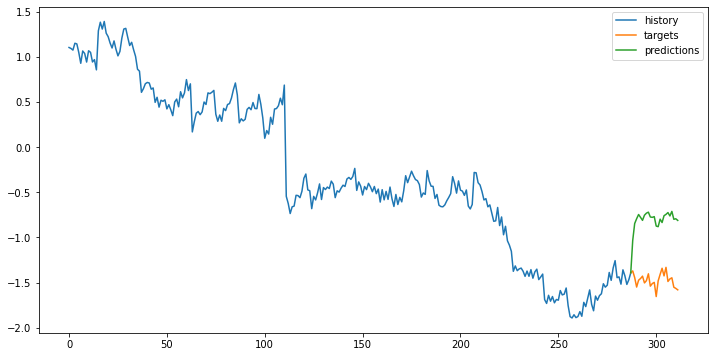

In [12]:
#model.load_weights("model_weights/checkpoints/cp-0001.ckpt")
generator.predict_and_plot(model, data_raw=test_data, start_positions=[0,100, 200, 300, 400, 500, 600, 700], save_plot=False)